1. 모든 단어 사용
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
2. 빈도수 상위 5,000개의 단어만 사용
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
사용할 모델 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤포레스트, 그래디언트 부스팅 트리, 보팅

3. 딥러닝 모델과 비교해 보기
위 과정을 통해 나온 최적의 모델과 단어수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

# Import

In [3]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier #Logistic Regression
from sklearn.naive_bayes import ComplementNB #CNB
from sklearn.tree import DecisionTreeClassifier #결정나무
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
from sklearn.ensemble import GradientBoostingClassifier #GBT
from sklearn.ensemble import VotingClassifier #보팅
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Data- 모든 단어 사용

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [5]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [6]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


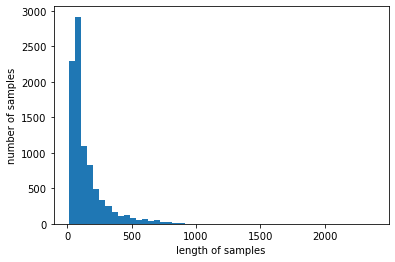

In [7]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<AxesSubplot:ylabel='count'>

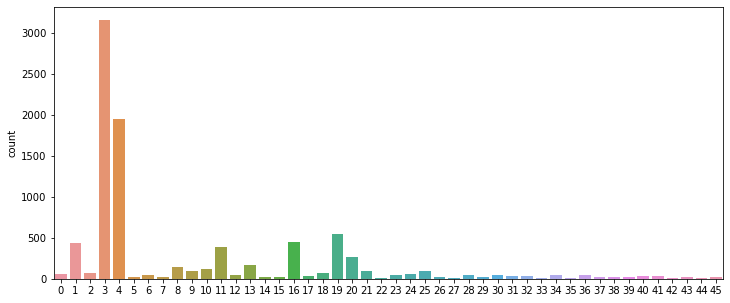

In [8]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [10]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [11]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [12]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [13]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [14]:
# Document Term Matrix(DTM)
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [15]:
# TF-IDF Matrix
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


# 다양한 모델 

- Naive Bayes

In [14]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.5997328584149599
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
   

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Complement Naive Bayes Classifier(CNB)

In [15]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


- Logistic Regression

In [16]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


- SVM

In [17]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7769367764915405


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


- Decision Tree

In [18]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


- Random Forest

In [19]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


- GradientBoostingclassifier

In [20]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


- Voting

In [21]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


# Data- 빈도수 상위 5,000개의 단어만 사용

In [31]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)


In [32]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index + 3 : word for word, index in word_index.items()}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [33]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [34]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [35]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [36]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


In [28]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


In [29]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


In [30]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7631344612644702


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


In [33]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


# 딥러닝 모델과 비교
- LSTM

In [16]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 5000, test_split = 0.2)

In [17]:
# https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221226716255
from tensorflow.keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [18]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [19]:

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [20]:
total_data_text = list(x_train) + list(x_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

문장길이 평균:  807.6473102956893
문장길이 최대:  9497
문장길이 표준편차:  842.057555792088


In [21]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('maxlen of pad_sequences: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. \n'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

maxlen of pad_sequences:  2491
전체 문장의 0.9431777698610616%가 maxlen 설정값 이내에 포함됩니다. 



In [22]:

x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)
print(x_test.shape)

(8982, 2491)
(2246, 2491)


In [23]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=46, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=46, dtype='float32')

In [24]:
vocab_size = 50000  # 어휘 사전의 크기입니다
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim)) # , input_shape=(None,)))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 46)                4646      
Total params: 5,085,046
Trainable params: 5,085,046
Non-trainable params: 0
_________________________________________________________________


In [25]:
x_val = x_train[:2000]
y_val = y_train[:2000]

partial_x_train = x_train[2000:]
partial_y_train = y_train[2000:]


In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  #몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
14/14 [==============================] - 7s 519ms/step - loss: 0.0966 - accuracy: 0.3303 - val_loss: 0.0782 - val_accuracy: 0.3400
Epoch 2/20
14/14 [==============================] - 7s 534ms/step - loss: 0.0744 - accuracy: 0.3551 - val_loss: 0.0731 - val_accuracy: 0.3400
Epoch 3/20
14/14 [==============================] - 7s 508ms/step - loss: 0.0720 - accuracy: 0.3551 - val_loss: 0.0723 - val_accuracy: 0.3400
Epoch 4/20
14/14 [==============================] - 7s 491ms/step - loss: 0.0717 - accuracy: 0.3551 - val_loss: 0.0723 - val_accuracy: 0.3400
Epoch 5/20
14/14 [==============================] - 7s 527ms/step - loss: 0.0716 - accuracy: 0.3551 - val_loss: 0.0722 - val_accuracy: 0.3400
Epoch 6/20
14/14 [==============================] - 7s 526ms/step - loss: 0.0717 - accuracy: 0.3551 - val_loss: 0.0723 - val_accuracy: 0.3400
Epoch 7/20
14/14 [==============================] - 7s 521ms/step - loss: 0.0716 - accuracy: 0.3551 - val_loss: 0.0723 - val_accuracy: 0.3400
Epoch 

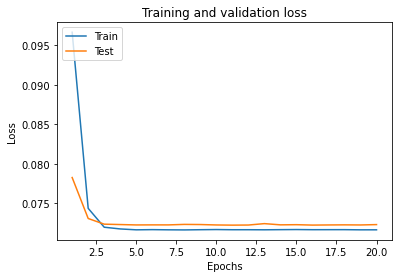

In [27]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Conclusion

다양한 모델중  LogisticRegression 모델과 Voting의 성능이 뛰어났다.    
하지만, Voting의 학습에 소요되는 시간이 훨씬 길었으므로 LogisiticRegression모델에 손을 들어 주겠다.   

딥러닝 모델은 LSTM을 사용했지만 만족할 만한 결과를 얻지는 못했다.   
이를 해결하기 위해 layer를 추가하던 전처리를 진행해야 할 것이다.